<center>

# **22AIE401 - Reinforcement Learning**  
# **Lab 7**  

</center>

### Team Members:
- Guruprasath M R - AIE22015  
- Rudraksh Mohanty - AIE22046  
- Shree Prasad M - AIE22050  
- Tharun Kaarthik G K - AIE22062  

---

### Objective:
Smart Drone Navigation using Dyna-Q 
To implement and understand the Dyna-Q reinforcement learning algorithm in a partially known  environment, enabling a delivery drone to learn the optimal path to its target while avoiding obstacles. 


---

### Problem Statement:
A delivery drone operates in an 8×8 urban grid. Its goal is to deliver a package from the warehouse at (0,0) to a drop point at (7,7). However, certain grid cells represent buildings/obstacles, and movement into them incurs a penalty. The drone must learn to reach the target location in the shortest path with minimal penalty using the Dyna-Q algorithm. 
 


---

## Original Code

In [1]:
!sudo apt update
!sudo apt install ffmpeg


Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app
Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app
Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app


FileNotFoundError: [WinError 2] The system cannot find the file specified

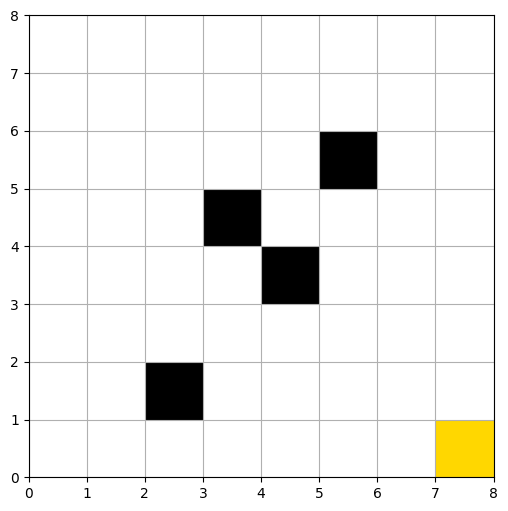

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches 
from matplotlib.animation import FuncAnimation, FFMpegWriter 
import random 
from collections import defaultdict 

# ---------------------- Environment Setup ---------------------- #
GRID_SIZE = 8
ACTIONS = ['U', 'D', 'L', 'R'] 
ACTION_MAP = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)} 
GOAL = (7, 7) 
OBSTACLES = {(3, 3), (4, 4), (2, 5), (6, 2)} 
REWARD_GOAL = 100
REWARD_STEP = -1
REWARD_OBSTACLE = -10
EPISODES = 300
MAX_STEPS = 50
EPSILON = 0.1
ALPHA = 0.1
GAMMA = 0.95
PLANNING_STEPS = 10
Q = defaultdict(lambda: {a: 0 for a in ACTIONS}) 
model = {} 

def is_valid(pos): 
    return 0 <= pos[0] < GRID_SIZE and 0 <= pos[1] < GRID_SIZE and pos not in OBSTACLES 

def step(state, action): 
    dx, dy = ACTION_MAP[action] 
    next_state = (state[0] + dx, state[1] + dy) 
    if not is_valid(next_state): 
        return state, REWARD_OBSTACLE 
    if next_state == GOAL: 
        return next_state, REWARD_GOAL 
    return next_state, REWARD_STEP 

def select_action(state): 
    if np.random.rand() < EPSILON: 
        return random.choice(ACTIONS) 
    return max(Q[state], key=Q[state].get) 

# ---------------------- Dyna-Q Training ---------------------- #
for ep in range(EPISODES): 
    state = (0, 0) 
    for _ in range(MAX_STEPS): 
        action = select_action(state) 
        next_state, reward = step(state, action) 
        # Q-learning update
        best_next = max(Q[next_state], key=Q[next_state].get) 
        Q[state][action] += ALPHA * (reward + GAMMA * Q[next_state][best_next] - Q[state][action]) 
        # Model learning
        model[(state, action)] = (next_state, reward) 
        # Planning updates
        for _ in range(PLANNING_STEPS): 
            s, a = random.choice(list(model.keys())) 
            s_, r = model[(s, a)] 
            best_s_ = max(Q[s_], key=Q[s_].get) 
            Q[s][a] += ALPHA * (r + GAMMA * Q[s_][best_s_] - Q[s][a]) 
        if next_state == GOAL: 
            break
        state = next_state 

# ---------------------- Extract Path ---------------------- #
path = [(0, 0)] 
state = (0, 0) 
for _ in range(30): 
    action = select_action(state) 
    state, _ = step(state, action) 
    path.append(state) 
    if state == GOAL: 
        break

# ---------------------- Visualization Setup ---------------------- #
fig, ax = plt.subplots(figsize=(6, 6)) 
drone_patch = patches.Circle((0.5, 0.5), 0.3, color='blue') 

def init(): 
    ax.clear() 
    ax.set_xlim(0, GRID_SIZE) 
    ax.set_ylim(0, GRID_SIZE) 
    ax.set_xticks(np.arange(GRID_SIZE + 1)) 
    ax.set_yticks(np.arange(GRID_SIZE + 1)) 
    ax.grid(True) 
    for i in range(GRID_SIZE): 
        for j in range(GRID_SIZE): 
            cell = (i, j) 
            color = 'white'
            if cell in OBSTACLES: 
                color = 'black'
            elif cell == GOAL: 
                color = 'gold'
            rect = patches.Rectangle((j, GRID_SIZE - i - 1), 1, 1, facecolor=color) 
            ax.add_patch(rect) 
    return [] 

def update(frame): 
    init() 
    rx, ry = path[frame] 
    drone_patch.center = (ry + 0.5, GRID_SIZE - rx - 0.5) 
    ax.add_patch(drone_patch) 
    return [drone_patch] 

anim = FuncAnimation(fig, update, frames=len(path), init_func=init, blit=True) 

# ---------------------- Save to Video ---------------------- #
save_path = "lab7_dyna_q_drone_navigation.mp4"
writer = FFMpegWriter(fps=2, metadata=dict(artist='RL Lab 7'), bitrate=1800) 
anim.save(save_path, writer=writer) 
print(f"✅ Drone navigation video saved as {save_path}")

## Task 1

The drone must pick up a payload at a pickup zone and then deliver it to any of multiple delivery
points. Add pickup_zone = (2,2) with no reward. Agent must first visit pickup, then reach one of multiple delivery goals [(3,9), (8,4), (9,9)] to finish the mission. Add a has_payload flag in the environment state.

In [ ]:
pickup_zone = (2, 2)
delivery_goals = [(3, 7), (7, 4), (7, 7)]  # Adjusted to fit 8x8 grid

class DroneEnv:
    def __init__(self):
        self.grid_size = GRID_SIZE
        self.obstacles = OBSTACLES
        self.pickup_zone = pickup_zone
        self.delivery_goals = delivery_goals
        self.reset()
    def reset(self):
        self.state = (0, 0)
        self.has_payload = False
        return self.state, self.has_payload
    def is_valid(self, pos):
        return 0 <= pos[0] < self.grid_size and 0 <= pos[1] < self.grid_size and pos not in self.obstacles
    def step(self, state, has_payload, action):
        dx, dy = ACTION_MAP[action]
        next_state = (state[0] + dx, state[1] + dy)
        reward = REWARD_STEP
        done = False
        if not self.is_valid(next_state):
            reward = REWARD_OBSTACLE
            next_state = state
        elif not has_payload and next_state == self.pickup_zone:
            has_payload = True
            reward = 0
        elif has_payload and next_state in self.delivery_goals:
            reward = REWARD_GOAL
            done = True
        return next_state, has_payload, reward, done

env = DroneEnv()
Q = defaultdict(lambda: {a: 0 for a in ACTIONS})
model = {}

for ep in range(EPISODES):
    state, has_payload = env.reset()
    for _ in range(MAX_STEPS):
        action = select_action((state, has_payload))
        next_state, next_payload, reward, done = env.step(state, has_payload, action)
        best_next = max(Q[(next_state, next_payload)], key=Q[(next_state, next_payload)].get)
        Q[(state, has_payload)][action] += ALPHA * (reward + GAMMA * Q[(next_state, next_payload)][best_next] - Q[(state, has_payload)][action])
        model[((state, has_payload), action)] = (next_state, next_payload, reward)
        for _ in range(PLANNING_STEPS):
            (s, p), a = random.choice(list(model.keys()))
            s_, p_, r = model[((s, p), a)]
            best_s_ = max(Q[(s_, p_)], key=Q[(s_, p_)].get)
            Q[(s, p)][a] += ALPHA * (r + GAMMA * Q[(s_, p_)][best_s_] - Q[(s, p)][a])
        if done:
            break
        state, has_payload = next_state, next_payload

# After training, extract and print the path for Task 1
path = []
state, has_payload = env.reset()
for _ in range(50):
    action = select_action((state, has_payload))
    next_state, next_payload, reward, done = env.step(state, has_payload, action)
    path.append((state, action, next_state, has_payload, reward))
    if done:
        break
    state, has_payload = next_state, next_payload
print("Task 1: Drone path (state, action, next_state, has_payload, reward):")
for step in path:
    print(step)

## Task 2

Migrate code to use function approximation for Q-value estimation.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    def forward(self, x):
        return self.fc(x)

def state_to_tensor(state, has_payload):
    return torch.tensor([state[0], state[1], int(has_payload)], dtype=torch.float32)

action_to_idx = {a: i for i, a in enumerate(ACTIONS)}
idx_to_action = {i: a for a, i in action_to_idx.items()}

qnet = QNet(3, len(ACTIONS))
optimizer = optim.Adam(qnet.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Track and print total reward per episode for Task 2
rewards_per_episode = []
for ep in range(EPISODES):
    state, has_payload = env.reset()
    total_reward = 0
    for _ in range(MAX_STEPS):
        s_tensor = state_to_tensor(state, has_payload)
        q_values = qnet(s_tensor)
        if np.random.rand() < EPSILON:
            action_idx = np.random.choice(len(ACTIONS))
        else:
            action_idx = torch.argmax(q_values).item()
        action = idx_to_action[action_idx]
        next_state, next_payload, reward, done = env.step(state, has_payload, action)
        next_s_tensor = state_to_tensor(next_state, next_payload)
        next_q_values = qnet(next_s_tensor)
        target = q_values.clone().detach()
        target[action_idx] = reward + GAMMA * torch.max(next_q_values).item()
        loss = loss_fn(q_values, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_reward += reward
        if done:
            break
        state, has_payload = next_state, next_payload
    rewards_per_episode.append(total_reward)
print("Task 2: Total reward per episode:")
print(rewards_per_episode)